In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import math  # This library is to use normal math functions like exp,sin etc.

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing dataset

In [ ]:
#below where the file is in gdrive, change with your
data_path = "/content/drive/MyDrive/Prnn/"
train_dataset = np.loadtxt(data_path + 'p3_train.csv', delimiter=',')
test_dataset = np.loadtxt(data_path + 'p3_test.csv', delimiter=',')

In [ ]:
# Creating base training and testing dataset
X_train_base = train_dataset[:,:10]
Y_train_base = train_dataset[:,10]
X_test_base = test_dataset[:,:10]
Y_test_base = test_dataset[:,10]

## Bayes Classifier

In [ ]:
classes = 5
features = 10

### GMM

In [ ]:
def p3_split_dataset(dataset,train_ratio):
  classes = np.unique(dataset[:,-1])
  dataset_size = dataset.shape[0]
  count = int(train_ratio*(dataset_size))

  np.random.shuffle(dataset)
  train_dataset, test_dataset = dataset[:count,:], dataset[count:,:]

  return train_dataset,test_dataset

In [ ]:
def p3_normalize_data(dataset):
  row_Max = np.amax(dataset[:,:-1], axis=0)
  row_Min = np.amin(dataset[:,:-1], axis=0)
  dataset = np.c_[(dataset[:,:-1]-row_Min)/(row_Max-row_Min),dataset[:,-1]]
  return dataset

In [ ]:
def p3_GMM_training(train_dataset,epochs,number_of_Gaussian):
  min_class = int(np.min(train_dataset[:,-1]))
  classes = int(len(np.unique(train_dataset[:,-1])))
  dimension = train_dataset.shape[1]-1
  Const = 1/np.power(2*math.pi,dimension/2)


  Category_wise_train_data = []
  for i in range(classes):
    Category_wise_train_data.append(train_dataset[train_dataset[:,-1]==(i+min_class)][:,:-1])

  Means = []
  Variance = []
  Pi = []

  for digit_class in range(classes):
    Category_wise_epochs = 0
    Category_wise_Means = np.random.uniform(0, 1,(dimension,number_of_Gaussian)) #np.zeros((dimension,number_of_Gaussian))
    Category_wise_Variance = np.identity(dimension)
    Category_wise_Variance = np.dstack([Category_wise_Variance]*number_of_Gaussian)

    Category_wise_Pi = np.ones(number_of_Gaussian)/number_of_Gaussian


    for Category_wise_epochs in range(epochs):
        # Calculating inverse of co-variance matrix
        Category_wise_Variance_inverse = np.identity(dimension)
        Category_wise_Variance_inverse = np.dstack([Category_wise_Variance_inverse]*number_of_Gaussian)

        for i in range(number_of_Gaussian):
            Category_wise_Variance_inverse[:,:,i] = np.linalg.inv(Category_wise_Variance[:,:,i])


        # calculating determinant
        Category_wise_Variance_det = np.zeros(number_of_Gaussian)

        for i in range(number_of_Gaussian):
            Category_wise_Variance_det[i] = np.linalg.det(Category_wise_Variance[:,:,i])


        Category_wise_Gamma = np.zeros((Category_wise_train_data[digit_class].shape[0],number_of_Gaussian))



        data_point_number = 0
        #Calculating Gamma for each datapoint and each class
        for data_point in Category_wise_train_data[digit_class]:
            Denominator = 0.0
            for k in range(number_of_Gaussian):
                temp1 = data_point-Category_wise_Means[:,k]
                temp2 = Category_wise_Variance_inverse[:,:,k]
                temp3 = (-1/2)*(temp1.T @ temp2 @ temp1)
                temp4 = np.exp(temp3)
                temp5 = np.power(Category_wise_Variance_det[k],-0.5)*temp4*Category_wise_Pi[k]
                Denominator += temp5

            Gamma_each_Gaussian = np.zeros(number_of_Gaussian)
            for k in range(number_of_Gaussian):
                temp6 = data_point-Category_wise_Means[:,k]

                temp7 = Category_wise_Variance_inverse[:,:,k]
                temp8 = (-1/2)*(temp6.T @ temp7 @ temp6)

                temp9 = np.exp(temp8)
                Numerator = np.power(Category_wise_Variance_det[k],-0.5)*temp9*Category_wise_Pi[k]

                Gamma_each_Gaussian[k] = (Numerator/Denominator)

            Category_wise_Gamma[data_point_number,:] = Gamma_each_Gaussian

            data_point_number += 1



        # Updating mean

        for k in range(number_of_Gaussian):
            meank = np.zeros(dimension)
            data_point_number = 0
            #updating mean in one line
            Category_wise_Means[:,k] = np.average(Category_wise_train_data[digit_class],axis = 0, weights=Category_wise_Gamma[:,k])



        Nk = np.sum(Category_wise_Gamma,axis = 0)

        for k in range(number_of_Gaussian):
            variancek = np.zeros((dimension,dimension))
            count = 0
            data_point_number = 0
            for data_point in Category_wise_train_data[digit_class]:
                v = data_point-Category_wise_Means[:,k]
                x = (v).reshape(v.shape[0],1)

                variancek = variancek + (x @ x.T ) * Category_wise_Gamma[data_point_number,k]
                data_point_number += 1

            Category_wise_Variance[:,:,k] = variancek/Nk[k]

            # retaining only diagonals
            temp = np.identity(len(Category_wise_Variance[:,:,k]))
            Category_wise_Variance[:,:,k] = Category_wise_Variance[:,:,k]*temp


        # Updating Pi


        Category_wise_Pi = Nk/Category_wise_train_data[digit_class].shape[0]

    Means.append(Category_wise_Means)
    Variance.append(Category_wise_Variance)
    Pi.append(Category_wise_Pi)
  return Means,Variance,Pi


In [ ]:
def p3_GMM_testing(test_dataset,classes,Means,Variance,Pi,number_of_Gaussian):
  min_class = int(np.min(test_dataset[:,-1]))
  dimension = test_dataset.shape[1]-1
  Variance_inverse = []
  # Calculating inverse of co-variance matrix
  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_inverse = np.identity(dimension)
      Category_wise_Variance_inverse = np.dstack([Category_wise_Variance_inverse]*number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_inverse[:,:,k] = np.linalg.inv(Category_wise_Variance[:,:,k])

      Variance_inverse.append(Category_wise_Variance_inverse)

  # Variance determinant
  Variance_det = []

  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_det = np.zeros(number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_det[k] = np.linalg.det(Category_wise_Variance[:,:,k])
      Variance_det.append(Category_wise_Variance_det)

  confusion_matrix = np.zeros((classes,classes))
  correct_predicted_labels = 0
  for data_point in test_dataset:
    probabilities = np.zeros(classes)

    for Class in range(classes):
      Inner_summation = 0.0

      for k in range(number_of_Gaussian):

        temp1 = data_point[:-1]-Means[Class][:,k]
        temp1 = (temp1).reshape(temp1.shape[0],1)
        temp2 = Variance_inverse[Class][:,:,k]
        temp3 = (-1/2)*(temp1.T @ temp2 @ temp1)
        temp4 = np.exp(temp3)
        temp5 = np.power(Variance_det[Class][k],-0.5)*temp4*Pi[Class][k]
        Inner_summation += temp5
      probabilities[Class] = Inner_summation

    predicted_class = np.argmax(probabilities) + min_class
    confusion_matrix[predicted_class-min_class][int(data_point[-1])-min_class] += 1
    if(predicted_class==int(data_point[-1])):
      correct_predicted_labels += 1


  accuracy = correct_predicted_labels/test_dataset.shape[0]

  return accuracy,confusion_matrix

In [ ]:
def p3_get_likelihood(dataset,Means,Variance,Pi,number_of_Gaussian):
  min_class = int(np.min(dataset[:,-1]))
  dimension = dataset.shape[1]-1
  Variance_inverse = []
  # Calculating inverse of co-variance matrix
  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_inverse = np.identity(dimension)
      Category_wise_Variance_inverse = np.dstack([Category_wise_Variance_inverse]*number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_inverse[:,:,k] = np.linalg.inv(Category_wise_Variance[:,:,k])

      Variance_inverse.append(Category_wise_Variance_inverse)

  # Variance determinant
  Variance_det = []

  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_det = np.zeros(number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_det[k] = np.linalg.det(Category_wise_Variance[:,:,k])
      Variance_det.append(Category_wise_Variance_det)

  log_likelihood = 0.0
  data_point_number = 0

  for data_point in dataset:
      Inner_summation = 0.0
      for k in range(number_of_Gaussian):
          temp1 = data_point[:-1]-Means[int(data_point[-1])-min_class][:,k]
          temp1 = (temp1).reshape(temp1.shape[0],1)
          temp2 = Variance_inverse[int(data_point[-1])-min_class][:,:,k]
          temp3 = (-1/2)*(temp1.T @ temp2 @ temp1)
          temp4 = np.exp(temp3)
          temp5 = np.power(Variance_det[int(data_point[-1])-min_class][k],-0.5)*temp4*Pi[int(data_point[-1])-min_class][k]
          Inner_summation += temp5

      log_likelihood += np.log(Inner_summation)

      data_point_number += 1

  return log_likelihood

In [ ]:
train_dataset = np.loadtxt('/content/drive/MyDrive/Prnn/p3_train.csv', delimiter=',', skiprows=0)
test_dataset = np.loadtxt('/content/drive/MyDrive/Prnn/p3_test.csv', delimiter=',', skiprows=0)

In [ ]:
train_dataset = p3_normalize_data(train_dataset)
test_dataset = p3_normalize_data(test_dataset)

Accuracy for  1  mixtures is :  0.5666
F1 scores for  1  mixtures is :  [0.5258532298227626, 0.5621639237412417, 0.6065422287931991, 0.5836831538601934, 0.5658965180605272]
Confusion matrix for  1  mixtures is :  [[1795.  526.  496.  508.  531.]
 [ 373. 1725.  339.  367.  352.]
 [ 185.  190. 1641.  173.  182.]
 [ 260.  213.  203. 1599.  229.]
 [ 358.  327.  361.  328. 1739.]]
Accuracy for  2  mixtures is :  0.5688666666666666
F1 scores for  2  mixtures is :  [0.5277330601492756, 0.5661848302744843, 0.6122979751068177, 0.5833181900781392, 0.56629653821032]
Confusion matrix for  2  mixtures is :  [[1803.  523.  495.  510.  531.]
 [ 370. 1743.  339.  366.  358.]
 [ 180.  177. 1648.  167.  171.]
 [ 260.  218.  206. 1605.  239.]
 [ 358.  320.  352.  327. 1734.]]
Accuracy for  3  mixtures is :  0.5696666666666667
F1 scores for  3  mixtures is :  [0.5305226174791392, 0.5643853389555628, 0.6106898464952839, 0.585792349726776, 0.5679659351457582]
Confusion matrix for  3  mixtures is :  [[1812. 

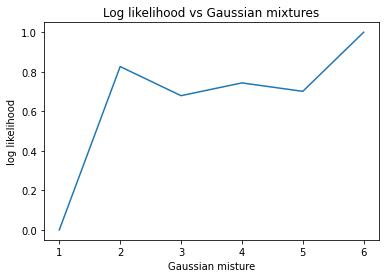

In [ ]:
classes = 5
y1 = np.zeros(6)
x1 = np.array([1,2,3,4,5,6])
for number_of_Gaussian in x1:
  Means1,Variance1,Pi1 = p3_GMM_training(train_dataset,5,number_of_Gaussian)
  accuracy1,confusion_matrix1 = p3_GMM_testing(test_dataset,5,Means1,Variance1,Pi1,number_of_Gaussian)
  TP1=[]
  TN1=[]
  FP1=[]
  FN1=[]
  F11=[]
  for i in range(classes):
    TP1.append(confusion_matrix1[i][i])
    TN1.append(np.sum(confusion_matrix1)-np.sum(confusion_matrix1[i,:])-np.sum(confusion_matrix1[:,i])+confusion_matrix1[i][i])
    FP1.append(np.sum(confusion_matrix1[i,:])-confusion_matrix1[i][i])
    FN1.append(np.sum(confusion_matrix1[:,i])-confusion_matrix1[i][i])
    F11.append((2*TP1[i])/(2*TP1[i] + FP1[i] + FN1[i]))
  y1[number_of_Gaussian-1] = p3_get_likelihood(train_dataset,Means1,Variance1,Pi1,number_of_Gaussian)
  print("Accuracy for ",number_of_Gaussian," mixtures is : ",accuracy1)
  print("F1 scores for ",number_of_Gaussian," mixtures is : ",F11)
  print("Confusion matrix for ",number_of_Gaussian," mixtures is : ",confusion_matrix1)

y1 = (y1-np.min(y1))/(np.max(y1)-np.min(y1))
plt.plot(x1,y1)
plt.title("Log likelihood vs Gaussian mixtures")
plt.xlabel("Gaussian misture")
plt.ylabel("log likelihood")
plt.show()

### Assuming class conditionals as Normal Density

Determining class conditional densities with variance

In [ ]:
# Creating list of numpy arrays containing training datas of each class with class as index of list
temp = train_dataset[:,:]
lst = []
for i in range(1,classes+1):
  x = temp[np.where(temp[:,10]==i)]
  x = x[:,:10]      #features = 10
  lst.append(x)

In [ ]:
# Initialising training and testing datas to base datas for this part
Y_train = Y_train_base
Y_test = Y_test_base
X_train = X_train_base
X_test = X_test_base

In [ ]:
mean=[]   # 10 features' mean for each classes
for i in range(classes):
  a=lst[i]
  a = a.mean(axis=0)
  mean.append(a)

In [ ]:
variance=[]    # Updating Variance
for i in range(classes):
  a=lst[i]-mean[i]
  v = a.T@a/lst[i].shape[0]
  v = np.linalg.inv(v)
  variance.append(v)

In [ ]:
variance[1].shape

(10, 10)

In [ ]:
X_test.shape

(15000, 10)

#### Training

In [ ]:
count = 0
for i in range(X_train.shape[0]):
  g = []                   #  Storing class conditionals of 5 classes
  for j in range(classes):
    v = (X_train[i]-mean[j])
    v=v.reshape((v.shape[0],1))
    k=0.5*v.T@variance[j]@v
    k = math.sqrt(np.linalg.det(variance[j]))*math.exp(-k)
    g.append(k)          #comparing exponent values
    #print(g)
  k = g.index(max(g)) +1
  #print(g)
  if k==Y_train[i]:
    count=count+1

In [ ]:
print('Accuracy is:',count*100/60000,' percent')

Accuracy is: 59.391666666666666  percent


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))

In [ ]:
count = 0
for i in range(X_test.shape[0]):
  g = []                   #  Storing class conditionals of 5 classes
  for j in range(classes):
    v = (X_test[i]-mean[j])
    v=v.reshape((v.shape[0],1))
    k=0.5*v.T@variance[j]@v
    k = math.sqrt(np.linalg.det(variance[j]))*math.exp(-k)
    g.append(k)
  k = g.index(max(g))         # comparing pre-exponent values
  if k==int(Y_test[i])-1:
    count=count+1
  v = int(Y_test[i])-1
  conf_matrix[v][k] += 1

In [ ]:
print('Testing Accuracy is:',count*100/15000,' percent')

Testing Accuracy is: 59.36  percent


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix)

The confusion matrix for above testing data is:
[[1627.  362.  264.  344.  374.]
 [ 380. 1742.  278.  268.  313.]
 [ 297.  298. 1914.  240.  291.]
 [ 321.  335.  255. 1794.  270.]
 [ 363.  310.  231.  302. 1827.]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.5460647759691223, 0.5779694757796947, 0.6399197592778335, 0.6057741009623502, 0.5982318271119843]


**bold text**## (vii) GMM

In [ ]:
def p3_split_dataset(dataset,train_ratio):
  classes = np.unique(dataset[:,-1])
  dataset_size = dataset.shape[0]
  count = int(train_ratio*(dataset_size))

  np.random.shuffle(dataset)
  train_dataset, test_dataset = dataset[:count,:], dataset[count:,:]

  return train_dataset,test_dataset

In [ ]:
def p3_normalize_data(dataset):
  row_Max = np.amax(dataset[:,:-1], axis=0)
  row_Min = np.amin(dataset[:,:-1], axis=0)
  dataset = np.c_[(dataset[:,:-1]-row_Min)/(row_Max-row_Min),dataset[:,-1]]
  return dataset

In [ ]:
def p3_GMM_training(train_dataset,epochs,number_of_Gaussian):
  min_class = int(np.min(train_dataset[:,-1]))
  classes = int(len(np.unique(train_dataset[:,-1])))
  dimension = train_dataset.shape[1]-1
  Const = 1/np.power(2*math.pi,dimension/2)


  Category_wise_train_data = []
  for i in range(classes):
    Category_wise_train_data.append(train_dataset[train_dataset[:,-1]==(i+min_class)][:,:-1])

  Means = []
  Variance = []
  Pi = []

  for digit_class in range(classes):
    Category_wise_epochs = 0
    Category_wise_Means = np.random.uniform(0, 1,(dimension,number_of_Gaussian)) #np.zeros((dimension,number_of_Gaussian))
    Category_wise_Variance = np.identity(dimension)
    Category_wise_Variance = np.dstack([Category_wise_Variance]*number_of_Gaussian)

    Category_wise_Pi = np.ones(number_of_Gaussian)/number_of_Gaussian


    for Category_wise_epochs in range(epochs):
        # Calculating inverse of co-variance matrix
        Category_wise_Variance_inverse = np.identity(dimension)
        Category_wise_Variance_inverse = np.dstack([Category_wise_Variance_inverse]*number_of_Gaussian)

        for i in range(number_of_Gaussian):
            Category_wise_Variance_inverse[:,:,i] = np.linalg.inv(Category_wise_Variance[:,:,i])


        # calculating determinant
        Category_wise_Variance_det = np.zeros(number_of_Gaussian)

        for i in range(number_of_Gaussian):
            Category_wise_Variance_det[i] = np.linalg.det(Category_wise_Variance[:,:,i])


        Category_wise_Gamma = np.zeros((Category_wise_train_data[digit_class].shape[0],number_of_Gaussian))



        data_point_number = 0
        #Calculating Gamma for each datapoint and each class
        for data_point in Category_wise_train_data[digit_class]:
            Denominator = 0.0
            for k in range(number_of_Gaussian):
                temp1 = data_point-Category_wise_Means[:,k]
                temp2 = Category_wise_Variance_inverse[:,:,k]
                temp3 = (-1/2)*(temp1.T @ temp2 @ temp1)
                temp4 = np.exp(temp3)
                temp5 = np.power(Category_wise_Variance_det[k],-0.5)*temp4*Category_wise_Pi[k]
                Denominator += temp5

            Gamma_each_Gaussian = np.zeros(number_of_Gaussian)
            for k in range(number_of_Gaussian):
                temp6 = data_point-Category_wise_Means[:,k]

                temp7 = Category_wise_Variance_inverse[:,:,k]
                temp8 = (-1/2)*(temp6.T @ temp7 @ temp6)

                temp9 = np.exp(temp8)
                Numerator = np.power(Category_wise_Variance_det[k],-0.5)*temp9*Category_wise_Pi[k]

                Gamma_each_Gaussian[k] = (Numerator/Denominator)

            Category_wise_Gamma[data_point_number,:] = Gamma_each_Gaussian

            data_point_number += 1



        # Updating mean

        for k in range(number_of_Gaussian):
            meank = np.zeros(dimension)
            data_point_number = 0
            #updating mean in one line
            Category_wise_Means[:,k] = np.average(Category_wise_train_data[digit_class],axis = 0, weights=Category_wise_Gamma[:,k])



        Nk = np.sum(Category_wise_Gamma,axis = 0)

        for k in range(number_of_Gaussian):
            variancek = np.zeros((dimension,dimension))
            count = 0
            data_point_number = 0
            for data_point in Category_wise_train_data[digit_class]:
                v = data_point-Category_wise_Means[:,k]
                x = (v).reshape(v.shape[0],1)

                variancek = variancek + (x @ x.T ) * Category_wise_Gamma[data_point_number,k]
                data_point_number += 1

            Category_wise_Variance[:,:,k] = variancek/Nk[k]

            # retaining only diagonals
            temp = np.identity(len(Category_wise_Variance[:,:,k]))
            Category_wise_Variance[:,:,k] = Category_wise_Variance[:,:,k]*temp


        # Updating Pi


        Category_wise_Pi = Nk/Category_wise_train_data[digit_class].shape[0]

    Means.append(Category_wise_Means)
    Variance.append(Category_wise_Variance)
    Pi.append(Category_wise_Pi)
  return Means,Variance,Pi


In [ ]:
def p3_GMM_testing(test_dataset,classes,Means,Variance,Pi,number_of_Gaussian):
  min_class = int(np.min(test_dataset[:,-1]))
  dimension = test_dataset.shape[1]-1
  Variance_inverse = []
  # Calculating inverse of co-variance matrix
  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_inverse = np.identity(dimension)
      Category_wise_Variance_inverse = np.dstack([Category_wise_Variance_inverse]*number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_inverse[:,:,k] = np.linalg.inv(Category_wise_Variance[:,:,k])

      Variance_inverse.append(Category_wise_Variance_inverse)

  # Variance determinant
  Variance_det = []

  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_det = np.zeros(number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_det[k] = np.linalg.det(Category_wise_Variance[:,:,k])
      Variance_det.append(Category_wise_Variance_det)

  confusion_matrix = np.zeros((classes,classes))
  correct_predicted_labels = 0
  for data_point in test_dataset:
    probabilities = np.zeros(classes)

    for Class in range(classes):
      Inner_summation = 0.0

      for k in range(number_of_Gaussian):

        temp1 = data_point[:-1]-Means[Class][:,k]
        temp1 = (temp1).reshape(temp1.shape[0],1)
        temp2 = Variance_inverse[Class][:,:,k]
        temp3 = (-1/2)*(temp1.T @ temp2 @ temp1)
        temp4 = np.exp(temp3)
        temp5 = np.power(Variance_det[Class][k],-0.5)*temp4*Pi[Class][k]
        Inner_summation += temp5
      probabilities[Class] = Inner_summation

    predicted_class = np.argmax(probabilities) + min_class
    confusion_matrix[predicted_class-min_class][int(data_point[-1])-min_class] += 1
    if(predicted_class==int(data_point[-1])):
      correct_predicted_labels += 1


  accuracy = correct_predicted_labels/test_dataset.shape[0]

  return accuracy,confusion_matrix

In [ ]:
def p3_get_likelihood(dataset,Means,Variance,Pi,number_of_Gaussian):
  min_class = int(np.min(dataset[:,-1]))
  dimension = dataset.shape[1]-1
  Variance_inverse = []
  # Calculating inverse of co-variance matrix
  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_inverse = np.identity(dimension)
      Category_wise_Variance_inverse = np.dstack([Category_wise_Variance_inverse]*number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_inverse[:,:,k] = np.linalg.inv(Category_wise_Variance[:,:,k])

      Variance_inverse.append(Category_wise_Variance_inverse)

  # Variance determinant
  Variance_det = []

  for i in range(len(Variance)):

      Category_wise_Variance = Variance[i]

      Category_wise_Variance_det = np.zeros(number_of_Gaussian)

      for k in range(number_of_Gaussian):
          Category_wise_Variance_det[k] = np.linalg.det(Category_wise_Variance[:,:,k])
      Variance_det.append(Category_wise_Variance_det)

  log_likelihood = 0.0
  data_point_number = 0

  for data_point in dataset:
      Inner_summation = 0.0
      for k in range(number_of_Gaussian):
          temp1 = data_point[:-1]-Means[int(data_point[-1])-min_class][:,k]
          temp1 = (temp1).reshape(temp1.shape[0],1)
          temp2 = Variance_inverse[int(data_point[-1])-min_class][:,:,k]
          temp3 = (-1/2)*(temp1.T @ temp2 @ temp1)
          temp4 = np.exp(temp3)
          temp5 = np.power(Variance_det[int(data_point[-1])-min_class][k],-0.5)*temp4*Pi[int(data_point[-1])-min_class][k]
          Inner_summation += temp5

      log_likelihood += np.log(Inner_summation)

      data_point_number += 1

  return log_likelihood

In [ ]:
train_dataset = np.loadtxt('/content/drive/MyDrive/Prnn/p3_train.csv', delimiter=',', skiprows=0)
test_dataset = np.loadtxt('/content/drive/MyDrive/Prnn/p3_test.csv', delimiter=',', skiprows=0)

In [ ]:
train_dataset = p3_normalize_data(train_dataset)
test_dataset = p3_normalize_data(test_dataset)

Accuracy for  1  mixtures is :  0.5666
F1 scores for  1  mixtures is :  [0.5258532298227626, 0.5621639237412417, 0.6065422287931991, 0.5836831538601934, 0.5658965180605272]
Confusion matrix for  1  mixtures is :  [[1795.  526.  496.  508.  531.]
 [ 373. 1725.  339.  367.  352.]
 [ 185.  190. 1641.  173.  182.]
 [ 260.  213.  203. 1599.  229.]
 [ 358.  327.  361.  328. 1739.]]
Accuracy for  2  mixtures is :  0.5688666666666666
F1 scores for  2  mixtures is :  [0.5277330601492756, 0.5661848302744843, 0.6122979751068177, 0.5833181900781392, 0.56629653821032]
Confusion matrix for  2  mixtures is :  [[1803.  523.  495.  510.  531.]
 [ 370. 1743.  339.  366.  358.]
 [ 180.  177. 1648.  167.  171.]
 [ 260.  218.  206. 1605.  239.]
 [ 358.  320.  352.  327. 1734.]]
Accuracy for  3  mixtures is :  0.5696666666666667
F1 scores for  3  mixtures is :  [0.5305226174791392, 0.5643853389555628, 0.6106898464952839, 0.585792349726776, 0.5679659351457582]
Confusion matrix for  3  mixtures is :  [[1812. 

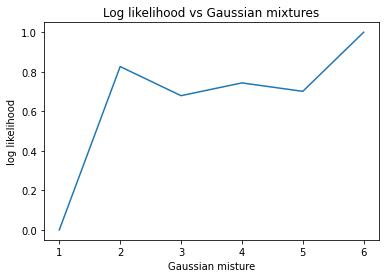

In [ ]:
classes = 5
y1 = np.zeros(6)
x1 = np.array([1,2,3,4,5,6])
for number_of_Gaussian in x1:
  Means1,Variance1,Pi1 = p3_GMM_training(train_dataset,5,number_of_Gaussian)
  accuracy1,confusion_matrix1 = p3_GMM_testing(test_dataset,5,Means1,Variance1,Pi1,number_of_Gaussian)
  TP1=[]
  TN1=[]
  FP1=[]
  FN1=[]
  F11=[]
  for i in range(classes):
    TP1.append(confusion_matrix1[i][i])
    TN1.append(np.sum(confusion_matrix1)-np.sum(confusion_matrix1[i,:])-np.sum(confusion_matrix1[:,i])+confusion_matrix1[i][i])
    FP1.append(np.sum(confusion_matrix1[i,:])-confusion_matrix1[i][i])
    FN1.append(np.sum(confusion_matrix1[:,i])-confusion_matrix1[i][i])
    F11.append((2*TP1[i])/(2*TP1[i] + FP1[i] + FN1[i]))
  y1[number_of_Gaussian-1] = p3_get_likelihood(train_dataset,Means1,Variance1,Pi1,number_of_Gaussian)
  print("Accuracy for ",number_of_Gaussian," mixtures is : ",accuracy1)
  print("F1 scores for ",number_of_Gaussian," mixtures is : ",F11)
  print("Confusion matrix for ",number_of_Gaussian," mixtures is : ",confusion_matrix1)

y1 = (y1-np.min(y1))/(np.max(y1)-np.min(y1))
plt.plot(x1,y1)
plt.title("Log likelihood vs Gaussian mixtures")
plt.xlabel("Gaussian misture")
plt.ylabel("log likelihood")
plt.show()

### Laplace Density

In [ ]:
# Initialising dataset for this part
X_train = np.absolute(train_dataset[:,:10])
Y_train = train_dataset[:,10]
X_test = np.absolute(test_dataset[:,:10])
Y_test = test_dataset[:,10]

In [ ]:
temp = train_dataset[:,:]
lst = []
for i in range(1,classes+1):
  x = temp[np.where(temp[:,10]==i)]
  x = x[:,:10]
  lst.append(x)

In [ ]:
# Finding Median
median=[]   # 10 features' exponential parameter for each classes
for i in range(classes):
  a=lst[i]
  a = np.median(a,axis=0)
  median.append(a)

In [ ]:
# Finding Sigma
sigma = []
for i in range(classes):
  s = np.zeros(10)  # 10 is size of features
  for j in range(lst[i].shape[0]):
    x=lst[i]
    s=s+np.absolute(x[j]-median[i])
  s=s/lst[i].shape[0]
  sigma.append(s)

#### Training

In [ ]:
count = 0
for i in range(X_train.shape[0]):
  g = []                   #  Storing class conditionals of 5 classes
  for j in range(classes):
    k=0
    s=1
    x = X_train[i]
    for l in range(10): # 10 is number of features
      k=k+abs(x[l]-median[j][l])/sigma[j][l]
      s = s*sigma[j][l]
    k = math.exp(-0.5*k)/s
    g.append(k)
  k = g.index(max(g)) +1
  if k==Y_train[i]:
    count=count+1

In [ ]:
print('Accuracy is:',count*100/X_train.shape[0],' percent')

Accuracy is: 48.79  percent


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))

In [ ]:
count = 0
for i in range(X_test.shape[0]):
  g = []                   #  Storing class conditionals of 5 classes
  for j in range(classes):
    k=0
    s=1
    x = X_test[i]
    for l in range(10): # 10 is number of features
      k=k+abs(x[l]-median[j][l])/sigma[j][l]
      s = s*sigma[j][l]
    k = math.exp(-0.5*k)/s
    g.append(k)
  k = g.index(max(g))
  if k==int(Y_test[i])-1:
    count=count+1
  v = int(Y_test[i])-1
  conf_matrix[v][k] += 1

In [ ]:
print('Accuracy is:',count*100/15000,' percent')

Accuracy is: 48.486666666666665  percent


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix)

The confusion matrix for above testing data is:
[[1058.  505.  464.  429.  515.]
 [ 303. 1432.  428.  384.  434.]
 [ 250.  388. 1746.  287.  369.]
 [ 255.  438.  414. 1462.  406.]
 [ 270.  409.  409.  370. 1575.]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.41433326806344234, 0.4654640013001788, 0.5371481310567605, 0.49500592517352293, 0.4974731522425774]
